# Introducción
## Filtro utilizado en los ejemplos
> Para los siguientes ejemplos se utilizará el filtro Low Pass Filter. Low Pass Filter realiza un filtrado en la imagen, utilizando una matriz mascara, que realizará una conversión de valor en cada uno de sus pixeles, para tener una imagen mas borrosa pero que eliminará el ruido de la imagen y permitira ver detalles que antes no eran visibles.

> Se utilizara la técnica convolution para obtener la matriz resultando.

## Convolution
> La técnica consiste en tomar cada pixel de una matriz y calcularle un nuevo valor multiplicandolo por una matriz mascara. El nuevo valor del pixel sera la suma del pixel y sus vecinos multiplicados por el valor de la matriz mascara en esa posicion.

> Se utiliza la siguiente formula:

> ![Imagen Convolution](https://wikimedia.org/api/rest_v1/media/math/render/svg/0f0005a6520eaab36f9b30520b640663d669d891)

> En la imagen la primera matriz corresponde a la de la imagen y la segunda a la matriz mascara.

> Para estos ejemplos utilizaremos la matriz mascara:
[[0, 1/8, 0]
[1/8, 1/4, 1/8]
[0, 1/8, 0]]






# Armado del ambiente
Para el armado del ambiente se necesita una imagen y se necesita instalar pycuda para la implementacion en GPU

In [1]:
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://i.stack.imgur.com/f6cBP.jpg" #@param {type:"string"}

#https://cdn.diffractionlimited.com/help/maximdl/image/M81Before.png
#@markdown --- 
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar información y resultado de ejecución. 
!wget {url_imagen} -O imagen.jpg

--2021-07-04 18:21:36--  https://i.stack.imgur.com/f6cBP.jpg
Resolving i.stack.imgur.com (i.stack.imgur.com)... 151.101.24.193
Connecting to i.stack.imgur.com (i.stack.imgur.com)|151.101.24.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31895 (31K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>]  31.15K  --.-KB/s    in 0.002s  

2021-07-04 18:21:36 (15.3 MB/s) - ‘imagen.jpg’ saved [31895/31895]



In [2]:
!pip install pycuda

     |████████████████████████████████| 1.7MB 9.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 9.8MB/s 
     |████████████████████████████████| 81kB 13.0MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627583 sha256=7e5cd98eb3a10b45605e289ef629dc9aea121ef7e74552e3108c31c29fffb643
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=30834593c2508a77f8b75a4f44019fc7dcecdf1332a8135d4263fbf5dbd144b3
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


# Implementacion en CPU con Python:

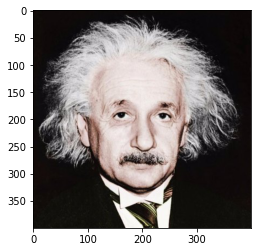

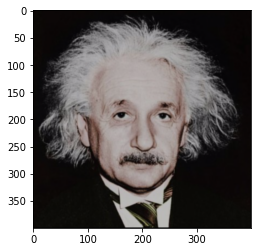

In [19]:
from datetime import datetime
from PIL import Image, ImageDraw
tiempo_img_total_cpu = datetime.now()
import  matplotlib.pyplot as plt

tiempo_img_cpu = datetime.now()
# Load image:
img_nombre = 'imagen.jpg'
input_image = Image.open( img_nombre ) 
input_pixels = input_image.load()

box_kernel = [[0, 1/8, 0],
              [1/8, 1/4, 1/8],
              [0, 1/8, 0]]

# Select kernel here:
kernel = box_kernel

# Middle of the kernel
offset = len(kernel) // 2

# Create output image
output_image = Image.new("RGB", input_image.size)
draw = ImageDraw.Draw(output_image)

# Compute convolution between intensity and kernels
for x in range(offset, input_image.width - offset):
    for y in range(offset, input_image.height - offset):
        acc = [0, 0, 0]
        for a in range(len(kernel)):
            for b in range(len(kernel)):
                xn = x + a - offset
                yn = y + b - offset
                pixel = input_pixels[xn, yn]
                acc[0] += pixel[0] * kernel[a][b]
                acc[1] += pixel[1] * kernel[a][b]
                acc[2] += pixel[2] * kernel[a][b]

        draw.point((x, y), (int(acc[0]), int(acc[1]), int(acc[2])))

tiempo_img_total_cpu = datetime.now() - tiempo_img_cpu

#print(tiempo_img_total_cpu)

# input_image.show("output.png")
plt.figure()
imgplot=plt.imshow(input_image)
plt.figure()
imgplot=plt.imshow(output_image)

# Implementacion con CUDA en GPU

In [4]:
from datetime import datetime
tiempo_img_total_gpu = datetime.now()

import numpy
from PIL import Image, ImageDraw
import  matplotlib.pyplot as plt
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

Thread: [ 16 , 16  ], Bloque : [ 25 , 25 ]
Total de Thread: [ 400 , 400  ]  =  160000
0:00:00.089383


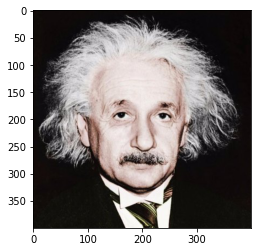

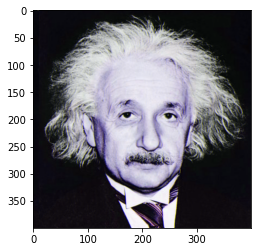

In [16]:
img_nombre = 'imagen.jpg'
input_image = Image.open(img_nombre)
tiempo_img_gpu = datetime.now()


kernel = numpy.array([[0, 1/8, 0],
          [1/8, 1/4, 1/8],
          [0, 1/8, 0]])


kernel_size = numpy.size(kernel)
img_ancho, img_alto = input_image.size

img_O_cpu = numpy.asarray(input_image)
img_I_cpu = img_O_cpu.astype(numpy.float32())
img_O_mask = kernel.astype( numpy.float32())
img_R_cpu = numpy.empty_like( img_O_cpu )

img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )
img_M_gpu = cuda.mem_alloc (img_O_mask.nbytes)

cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_O_gpu, img_R_cpu )
cuda.memcpy_htod( img_M_gpu, img_O_mask)

module = SourceModule("""
#include <stdio.h>
__global__ void conv_img_cpu(float *img, float *kernel, float *imgf, int Nx, int Ny, int kernel_size) {
  //each block is assigned to a row of an image, iy integer index of y
  int iy = blockIdx.y * blockDim.y + threadIdx.y; 

  //each thread is assigned to a pixel of a row, ix integer index of x
  int ix = blockIdx.x * blockDim.x + threadIdx.x; 

  int center = (kernel_size -1)/2;

  int idx = iy*Nx +ix;
  int sum = 0;
  printf("Suma: %d", sum);
  if (idx<Nx*Ny){
    for (int ki = 0; ki<kernel_size; ki++)
        for (int kj = 0; kj<kernel_size; kj++){
           int ii = kj + ix - center;
           int jj = ki + iy - center;
    sum+=img[jj*Nx+ii]*kernel[ki*kernel_size + kj];
    }
    imgf[idx] = sum;
  }

}
""")

function = module.get_function("conv_img_cpu")

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 16
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

function( img_O_gpu, img_M_gpu, img_R_gpu, numpy.int32(img_ancho), numpy.int32(img_alto) , numpy.int32(kernel_size) , block=(dim_hilo_x, dim_hilo_y, 1), grid=(dim_bloque_x, dim_bloque_y,1))

tiempo_img_total_gpu = datetime.now() - tiempo_img_gpu

print(tiempo_img_total_gpu)
#Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

#Metricas

Tiempo en CPU: 2131.044 [ms]
Tiempo en GPU: 89.383 [ms]


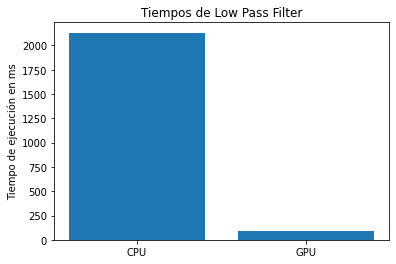

In [20]:
print('Tiempo en CPU:', tiempo_en_ms(tiempo_img_total_cpu), '[ms]')
print('Tiempo en GPU:', tiempo_en_ms(tiempo_img_total_gpu), '[ms]')

## Declaramos valores para el eje x
eje_x = ['CPU', 'GPU']
 
## Declaramos valores para el eje y
eje_y = [tiempo_en_ms(tiempo_img_total_cpu),tiempo_en_ms(tiempo_img_total_gpu)]
 
## Creamos Gráfica
plt.bar(eje_x, eje_y)
 
## Legenda en el eje y
plt.ylabel('Tiempo de ejecución en ms')
 
## Legenda en el eje x
 
## Título de Gráfica
plt.title('Tiempos de Low Pass Filter')
 
## Mostramos Gráfica
plt.show()

#Conclusion

Debido al uso de la paralelización cada thread realiza las operaciones para un pixel, achicando los tiempos que tardara el algoritmo en realizar el procesamiento y devolver la matriz resultante. También puede verse que para el algoritmo en CPU, es necesario realizar cuatro ciclos, mientras que para el algoritmo en GPU, la complejidad computacional es menor, porque al hacer uso de threads ya no es necesario recorrer todas las filas y columnas.

#Bibliografia


*   https://www.sciencedirect.com/science/article/pii/S1877050916001976
*   https://en.wikipedia.org/wiki/Kernel_(image_processing)
*   https://ulhpc-tutorials.readthedocs.io/en/latest/cuda/exercises/convolution/